# **Using `Prophet` for Time Series Analysis and Forecasting:**

Prophet is a open source time series forecasting algorithm designed by facebook for ease of use without  any expert knowledge in statistics or time series forecasting. Prophet builds a model by finding a best smooth line which can be represented as a **sum of the following components:**

**y(t) = g(t) + s(t) + h(t) + ϵₜ**

- Overall growth trend. g(t)
- Yearly seasonality. s(t)
- Weekly seasonality. s(t)
- Holidays effects h(t)

This notebook demonstrates some useful functions present in **`fbprophet`**(python library) listed below with an example:

1. **`Prophet.fit`**
2. **`Prophet.predict`**
3. **`Prophet.plot`**
4. **`Prophet.plot_components`**
5. **`Prophet.add_seasonality`**
6. **`Prophet.add_regressors`**
7. **`Prophet.seasonalities`**
8. **`Prophet.predictive_samples`**
9. **`Prophet.predict_seasonal_components`**


## **Data Description**

We will be using a synthethic daily time series data(shown below) with columns (**`date`**, **`target`**, **`regr1`**, **`regr2`**) for 180 days, where **`target`** unique value for each day and **`regr1`**, **`regr2`** are external factor which effect the target value.

In [2]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()

In [3]:
# loading the time series data into a dataframe
df = pd.read_csv('ts_with_2regressors.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

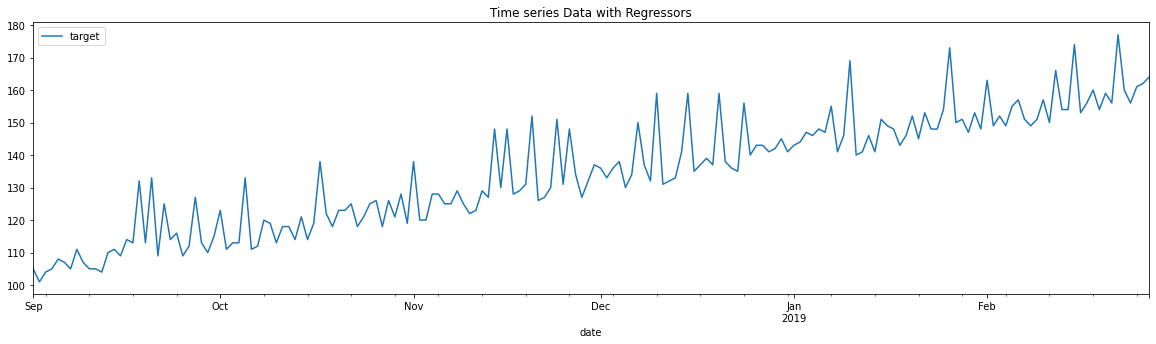

In [4]:
# plotting the time series data
ax = df.plot(x='date', y='target', figsize=(20, 5), title='Time series Data with Regressors')

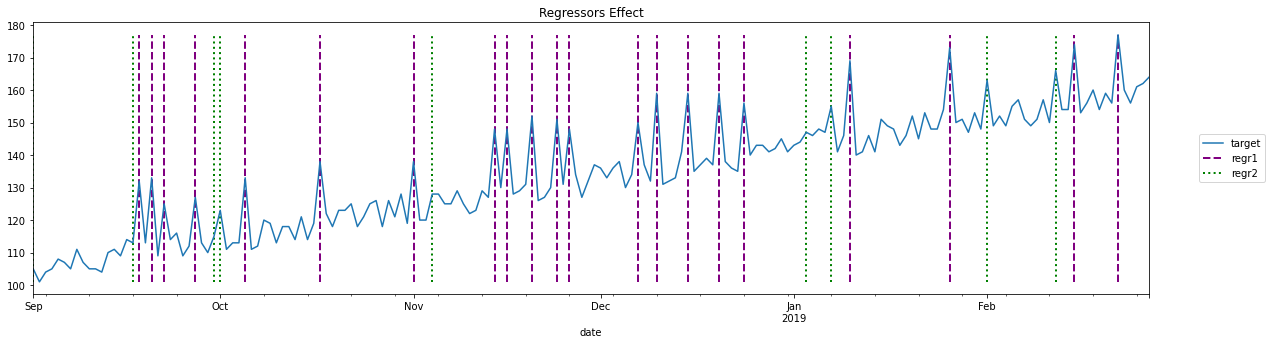

In [5]:
# plotting the effect of regressors
ax = df.plot(x='date', y='target', figsize=(20, 5), title='Regressors Effect')

ticks, _ = plt.xticks()

y_min = df.target.min()
y_max = df.target.max()

plt.vlines(x=list(df[df['regr1'] == 1]['date'].values), ymin=y_min, ymax=y_max, colors='purple', ls='--', lw=2, label='regr1')
plt.vlines(x=list(df[df['regr2'] == 1]['date'].values), ymin=y_min, ymax=y_max, colors='green', ls=':', lw=2, label='regr2')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.show();

Let us now see how to use the above listed functions:

## 1. Generating a Forecast:
- Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit(**`Prophet.fit`**)  and predict(**`Prophet.predict`**) methods.
- The input to Prophet is always a dataframe with two columns: ds and y. The **`ds`** (datestamp) column should be of a format expected by Pandas, 
  ideally **`YYYY-MM-DD`** for a date or **`YYYY-MM-DD HH:MM:SS`** for a timestamp. The **`y`** column must be numeric, 
  and represents the measurement we wish to forecast.
- For demonstration we will use the **`target`** values for first 150 days as training data predict target for all 180 days.

**Note** : For this step we will be considering only the **`date`** and **`target`** columns

In [6]:
# Creating train and predict dataframed

df = df.rename(columns={'date':'ds', 'target':'y'})

df_train = df[['ds', 'y']].iloc[:150]
df_predict = df[['ds']]

print(df_train.shape, df_predict.shape)

(150, 2) (180, 1)


In [7]:
df_train.head()

,ds,y
0,2018-09-01,105
1,2018-09-02,101
2,2018-09-03,104
3,2018-09-04,105
4,2018-09-05,108


In [8]:
df_predict.head()

,ds
0,2018-09-01
1,2018-09-02
2,2018-09-03
3,2018-09-04
4,2018-09-05


In [9]:
%%time

# Fitting a Prophet model
model = Prophet()
model.fit(df_train)
forecast = model.predict(df_predict)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
CPU times: user 989 ms, sys: 53.6 ms, total: 1.04 s
Wall time: 1.07 s


In [10]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-09-01,106.798564,98.234263,115.918676,106.798564,106.798564,0.296638,0.296638,0.296638,0.296638,0.296638,0.296638,0.0,0.0,0.0,107.095202
1,2018-09-02,107.113938,96.369075,114.188247,107.113938,107.113938,-2.097738,-2.097738,-2.097738,-2.097738,-2.097738,-2.097738,0.0,0.0,0.0,105.016200
2,2018-09-03,107.429312,100.059238,117.050160,107.429312,107.429312,1.167575,1.167575,1.167575,1.167575,1.167575,1.167575,0.0,0.0,0.0,108.596887
3,2018-09-04,107.744686,97.811862,116.541493,107.744686,107.744686,-0.252002,-0.252002,-0.252002,-0.252002,-0.252002,-0.252002,0.0,0.0,0.0,107.492684
4,2018-09-05,108.060060,97.219618,115.460788,108.060060,108.060060,-1.703072,-1.703072,-1.703072,-1.703072,-1.703072,-1.703072,0.0,0.0,0.0,106.356988


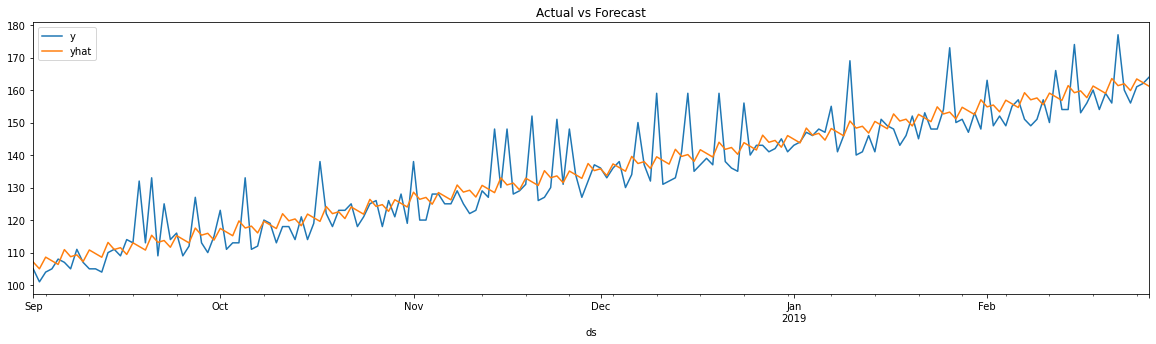

In [11]:
# plotting the actual and forecast values

ax = (df.plot(x='ds',y='y',figsize=(20,5),title='Actual Vs Forecast'))
forecast.plot(x='ds',y='yhat',figsize=(20,5),title='Actual vs Forecast', ax=ax)

From the above ouptut we can see that prophet pretty much gave a good fit on the data, but still it is unable to capture the sudden jumps 
in the data. These jumps are basically caused by the external regressors which prophet is unable to detect by default. We will see how to model
Prophet to capture these external factors in the coming sections.

# 2. Plotting the Forecast :
- We can plot the forecast and the components by calling the **`Prophet.plot`** & **`Prophet.plot_components`** method and passing in the forecast dataframe  as shown below
- The forecast plot is a single  graph containing a scatter plot of historical data points indicated by black dots and the forecast/fitted curve indicated by a blue line.
  The graph also contains a light blue shaded region which corresponds to the uncertainty bands.
- The components plot is a group of plots corresponding to various time series components(**`trend`**, **`seasoanilities`**) and external effects.

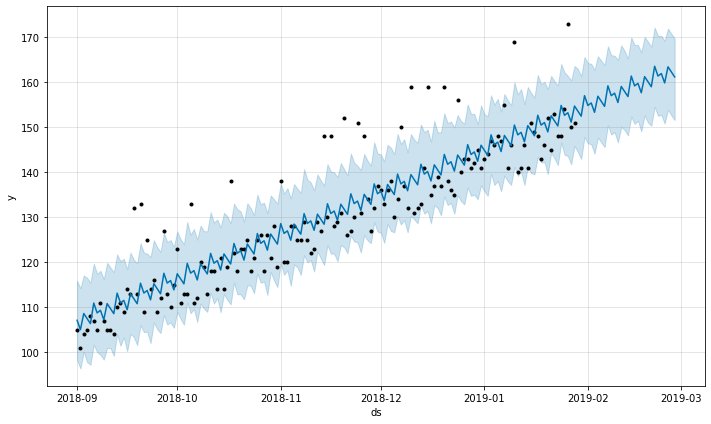

In [12]:
# Plotting the generated forecast
fig1 = model.plot(forecast, uncertainty=True)

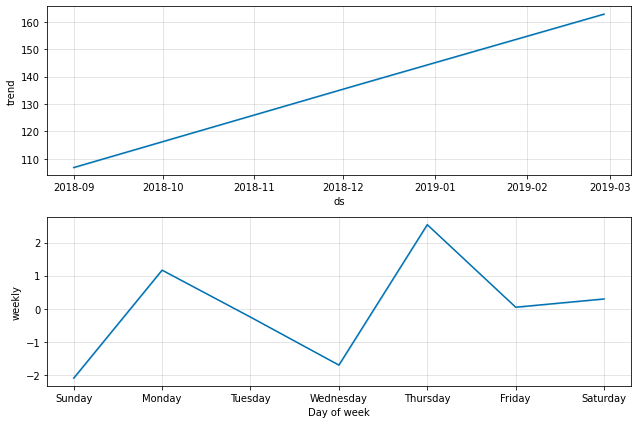

In [13]:
# Plotting the time series components
fig2 = model.plot_components(forecast)

We can see that by default Prophet has computed the **`trend`** and **`weekly_seasonality`** based on the training data.

## 3. Adding Custom Seasonalities and Regressors

- In Prophet we can model custom seasonalities using the functions **`Prophet.add_seasonality`**.
- By default Prophet automatically models a  additive **`daily`**, **`weekly`**, **`yearly`** seasonalities based on available training data.
- We can get the details of inferred seasoanlities using the function **`Prophet.seasonalities`**
- Let us now use the above method to model a **`monthly`** seasonality.

In [14]:
%%time

# Modelling a custom monthly seasonality
model2 = Prophet()
model2.add_seasonality(name='custom_monthly', period=30.5, fourier_order=10)

model2.fit(df_train)
forecast2 = model2.predict(df_predict)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
CPU times: user 975 ms, sys: 50.3 ms, total: 1.03 s
Wall time: 1.02 s


In [15]:
model2.seasonalities

OrderedDict([('custom_monthly',
              {'period': 30.5,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None}),
             ('weekly',
              {'period': 7,
               'fourier_order': 3,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

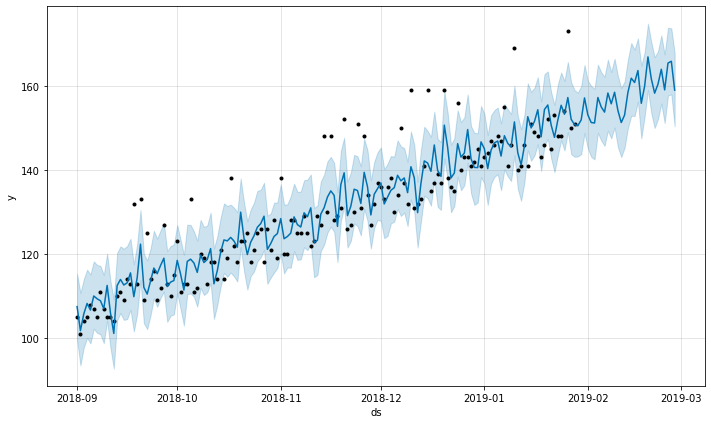

In [16]:
fig1 = model2.plot(forecast2, uncertainty=True)

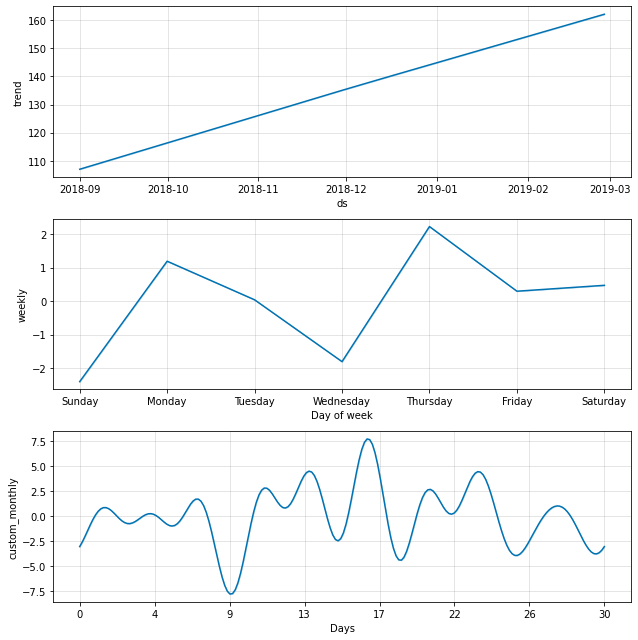

In [17]:
fig2 = model2.plot_components(forecast2, uncertainty=True)

- From the above graph We can see that the Prophet has modelled a custom_monthly seasonality and the forecast is also a bit modified compared to the default forecast.
- Similar to seasoanlities prophet also has a way to capture/model external factors which have an effect on the target value using the function **`Prophet.add_regressors`**.
- In the sample data we are using we have mentioned that there are two external regressors which are effecting the target value.
- In order to model and predict the regressor effects, both the training and prediction dataframes should contain the regressor data.
- Let us now see how to model these regressors using the above function.

**Note** : The regressor's should be numeric values, you will have to perform one hot encoding if the regressor contains string data.

In [18]:
# adding regressor data in historical and future dates
df_train3 = (df[['ds', 'y', 'regr1', 'regr2']]
             .iloc[:150]
             .copy())
df_predict3 = df[['ds', 'regr1', 'regr2']].copy()

In [19]:
%%time

# modelling external regressors prior to fitting
model3 = Prophet()
model3.add_regressor('regr1')
model3.add_regressor('regr2')


# fit and predcit
model3.fit(df_train3)
forecast3 = model3.predict(df_predict3)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
CPU times: user 967 ms, sys: 67.2 ms, total: 1.03 s
Wall time: 1.03 s


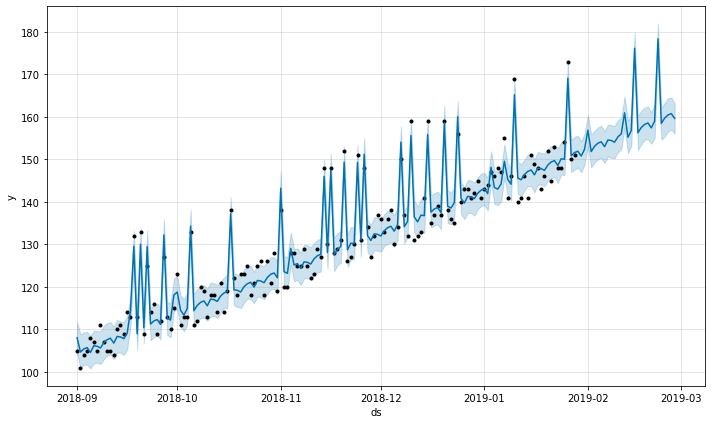

In [20]:
fig1 = model3.plot(forecast3, uncertainty=True)

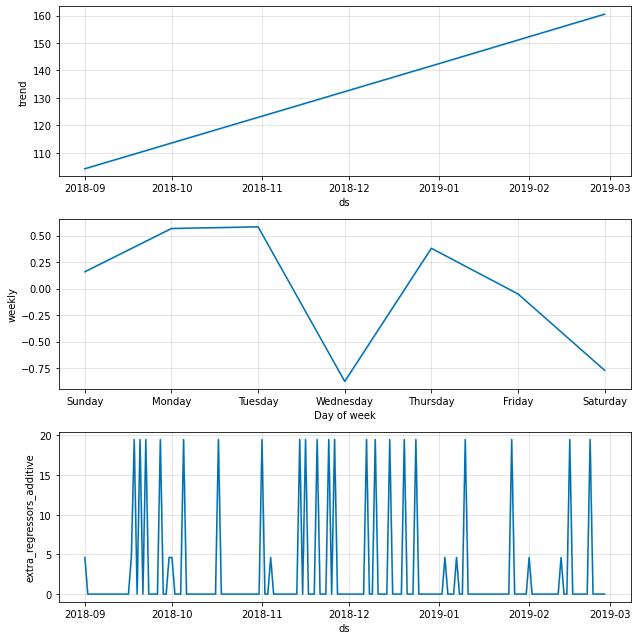

In [21]:
fig2 = model3.plot_components(forecast3, uncertainty=True)

From the above output we can observe that the model has pretty much captured the two external effects, from the ouptut graph we can that there is approx 5% and 20% lift on the target value 
w.r.t the regressors.

## 3. Fetching Posterior Samples

- Prophet has a way to access the posterior samples for a particular day in history and future using the function **`Prophet.predictive_samples`**
- By default prophet generates 1000 samples for estimating the upper and lower bound's of the uncertainity bands.
- We can modify the no of samples at the time of prophet instantiation using the parameter **`uncertainty_samples`**
- let us now see how can we generate a dataframe with posterior samples for 1 week in the prediction dataframe.

In [22]:
df_1wk = df_predict3.iloc[:7]
df_1wk

,ds,regr1,regr2
0,2018-09-01,0,1
1,2018-09-02,0,0
2,2018-09-03,0,0
3,2018-09-04,0,0
4,2018-09-05,0,0
5,2018-09-06,0,0
6,2018-09-07,0,0


In [23]:
# fetching the posterior samples.
samples = model3.predictive_samples(df_1wk)
df_samples = pd.DataFrame(data=samples['yhat'], index=df_1wk['ds']).reset_index()
df_samples

,ds,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
0,2018-09-01,107.170417,104.548623,110.177574,109.634767,111.975202,103.736419,110.892236,103.824875,104.643831,...,103.958105,109.883839,108.994881,108.347248,110.939013,112.497150,107.601783,102.063989,110.452631,106.108154
1,2018-09-02,102.767730,105.092584,104.890159,102.644497,105.126953,107.286211,106.114199,102.491740,106.875472,...,102.796293,96.630018,108.450798,109.064013,105.644189,105.925876,104.236877,103.571305,103.466752,105.954269
2,2018-09-03,103.458351,103.527893,105.817802,105.466889,109.116866,108.067173,100.700284,103.327593,104.697424,...,106.536728,104.685321,103.647290,106.408273,105.360721,101.294988,104.445538,104.227113,107.511757,103.961730
3,2018-09-04,106.390080,102.979160,105.625275,108.301645,110.350148,105.734095,108.808986,106.840932,102.765332,...,103.259145,104.536465,109.846353,102.454991,104.789295,104.363957,109.085785,108.666029,100.993815,103.300566
4,2018-09-05,105.049256,108.140130,105.132630,104.554342,102.404025,107.974793,102.253884,101.493454,101.030333,...,100.750947,110.976341,110.614543,107.996956,108.351092,103.066460,102.598589,97.560496,107.113112,104.149007
5,2018-09-06,106.470336,108.222524,101.885925,104.088476,111.172294,105.262959,108.543142,109.345958,104.392584,...,107.465187,106.525943,108.294914,113.198405,106.734582,104.845337,107.908873,105.161065,104.156932,107.155563
6,2018-09-07,106.252706,109.417090,105.450205,105.187858,109.326349,105.911672,105.956994,104.238099,100.563354,...,101.089949,110.160694,107.723571,105.614023,105.021308,105.884763,105.425327,106.406087,104.078052,106.824053


In [24]:
# Forecast 
forecast3[forecast3['ds'] == '2018-09-02'][['ds', 'yhat']]

,ds,yhat
1,2018-09-02,104.644103


In [25]:
# Mean of the posterior samples.
df_samples[df_samples['ds'] == '2018-09-02'].set_index('ds').mean(axis=1)

ds
2018-09-02    104.651337
dtype: float64

We can observe that the mean of the posterior samples is almost equal to the forecast value for a particular day.

# 4. Fetching Trend and Seasonality Profiles.

- As already mentioned Prophet automatically detects trend and seasoanlities based on the historical data, we can fetch the individual seasonality values using the function 
  **`Prophet.predict_seasoanl_components`**.
- By default Prophet gives a weekly profile(one value for each day in a week) from Sunday to Saturday.
- similarly it generates a yearly profile(one value for each day in a year) from year Jan to Dec based on the available data.
- Let us now see how to use the above function to fetch the seasonality profiles.

In [26]:
# Generating the dates for 1week from Sunday to Monday in tht future

date = pd.Timestamp(df_predict['ds'].min())
sunday = date + pd.Timedelta(days=(6 - (date.weekday()%7)))
saturday = sunday + pd.Timedelta(days=6)

df_weekly = df_predict3[(df_predict3['ds'] >= sunday) & (df_predict3['ds'] <= saturday)].reset_index(drop=True)
df_weekly

,ds,regr1,regr2
0,2018-09-02,0,0
1,2018-09-03,0,0
2,2018-09-04,0,0
3,2018-09-05,0,0
4,2018-09-06,0,0
5,2018-09-07,0,0
6,2018-09-08,0,0


In [27]:
# Fetching the weekly profile
weekly_profile = model3.predict_seasonal_components(df_weekly)
weekly_profile

,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,regr1,regr1_lower,regr1_upper,regr2,regr2_lower,regr2_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper
0,0.160074,0.160074,0.160074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160074,0.160074,0.160074,0.0,0.0,0.0
1,0.568040,0.568040,0.568040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.568040,0.568040,0.568040,0.0,0.0,0.0
2,0.583790,0.583790,0.583790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.583790,0.583790,0.583790,0.0,0.0,0.0
3,-0.874673,-0.874673,-0.874673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.874673,-0.874673,-0.874673,0.0,0.0,0.0
4,0.381563,0.381563,0.381563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.381563,0.381563,0.381563,0.0,0.0,0.0
5,-0.049153,-0.049153,-0.049153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.049153,-0.049153,-0.049153,0.0,0.0,0.0
6,-0.769643,-0.769643,-0.769643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.769643,-0.769643,-0.769643,0.0,0.0,0.0


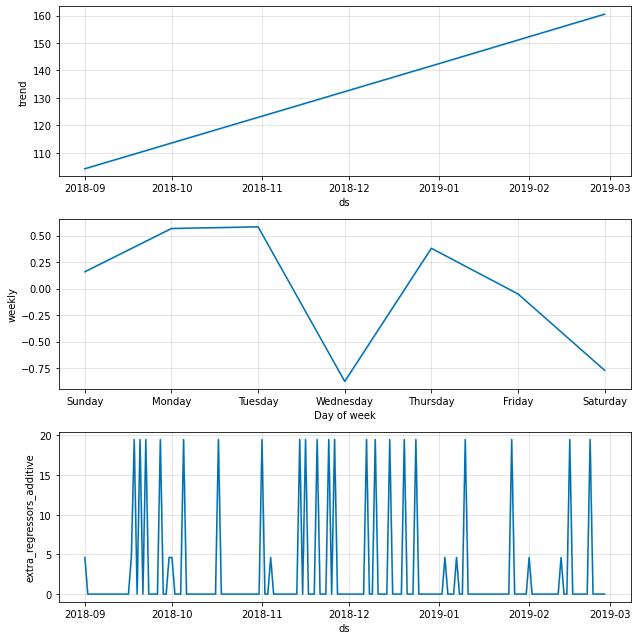

In [28]:
fig = model3.plot_components(forecast3)

We can see that the values in the **`weekly`** exactly match the values in the components plot. Similarly we can generate the seasoanlity profiles of custom seasoanlities as well.